# **Import of libraries and necessary packages**

In [1]:
!pip install utils
!pip install Pillow

In [2]:
import pandas as pd
import numpy as np
import os
import cv2
import PIL
from PIL import *
from PIL import Image
import timeit
import cv2
from matplotlib import pyplot as plt
from os import listdir
from os.path import isdir
import numpy as np
from numpy import savez_compressed
from numpy import asarray

import tensorflow
import keras
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Activation, Flatten  
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,AveragePooling2D, LSTM, MaxPool1D, GlobalMaxPooling1D, Embedding
from keras.losses import categorical_crossentropy  
from keras.regularizers import l2 
from keras.utils import np_utils  

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator 

from sklearn import preprocessing
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf 
from keras.callbacks import ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

# **Reading the dataset**

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
dataset = pd.read_csv('/content/gdrive/MyDrive/CNN/Hate_speech/Twitter_Sentiment_Analysis/tweets.csv')

In [ ]:
dataset

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."


Characteristics of the dataset:

- the tweets were taken from Tweeter, so they include unofficial and official forms of expression, hashtags, abbreviations, linguistic mistakes and slang,
- all usernames (mentions) have been replaced by "@user".

# **Data pre-processing**

**Types of tweets in the dataset**

In [5]:
print("Hate speech: {}\nNot hate speech: {}".format(
    (dataset.label == 1).sum(),
    (dataset.label == 0).sum()
))

Hate speech: 2242
Not hate speech: 29720


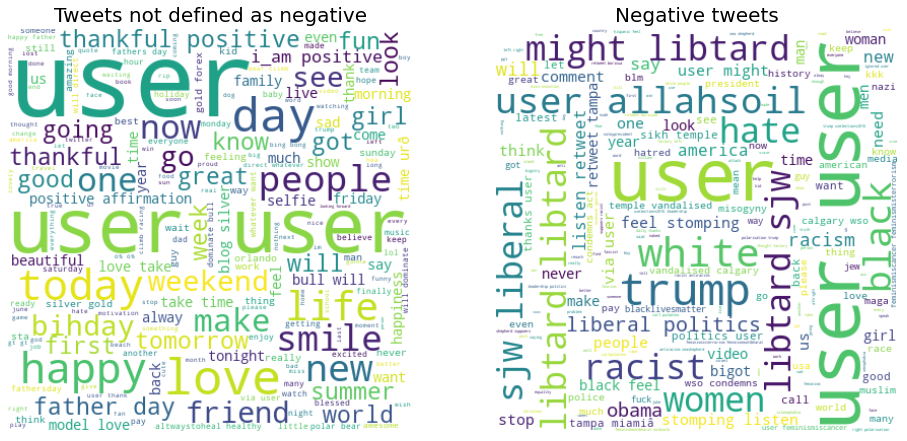

In [6]:
from wordcloud import WordCloud, STOPWORDS
stopwords = STOPWORDS.add('amp')

neutral_words = ' '.join(dataset[dataset.label == 0].tweet.values)
hatred_words = ' '.join(dataset[dataset.label == 1].tweet.values)

plt.figure(figsize=(16, 8))

cloud1 = WordCloud(width = 400, height = 400, background_color='white', stopwords = stopwords).generate(neutral_words)
plt.subplot(121)
plt.imshow(cloud1, interpolation = "bilinear")
plt.axis("off")
plt.title('Tweets not defined as negative', size = 20)

cloud2 = WordCloud(width = 400, height = 400, background_color = 'white', stopwords = stopwords).generate(hatred_words)
plt.subplot(122)
plt.imshow(cloud2, interpolation = "bilinear")
plt.axis("off")
plt.title('Negative tweets', size = 20)
plt.show()

## **Removal of the hashtags**

We extracted hashtags from each tweet as an additional column, for later analysis.

In [7]:
hashtags = dataset['tweet'].str.extractall('#(?P<hashtag>[a-zA-Z0-9_]+)').reset_index().groupby('level_0').agg(lambda x: ' '.join(x.values))
dataset.loc[:, 'hashtags'] = hashtags['hashtag']
dataset['hashtags'].fillna('', inplace = True)

## **Removal of user mentions (nicknames)**

Removal of mentions (@user), but counting the number of mentions in the tweet (possible further analysis of the relation between the number of mentions and the tone of the tweet).

In [8]:
dataset.loc[:, 'mentions'] = dataset['tweet'].str.count('@[a-zA-Z0-9_]+')

dataset.tweet = dataset.tweet.str.replace('@[a-zA-Z0-9_]+', '')

## **Removal of punctuation**

It does not contribute any additional information when processing text data, moreover, its removal reduces the size of the treng data (faster training of the model).

In [10]:
dataset.tweet = dataset.tweet.str.replace('[^\w\s]','')

## **Removal of capital letters**

This avoids making multiple copies of the same words, e.g. when calculating the word count, 'Hate' and 'hate' would be treated as different words.

In [11]:
dataset.tweet = dataset.tweet.str.lower()

## **Removal of individual characters**

In [12]:
dataset.tweet = dataset.tweet.str.replace(r"\s+[a-zA-Z]\s+", ' ')

## **Removal of everything except words**

Replacing anything that is not a word with a space (so that the words do not merge).

In [ ]:
dataset.tweet = dataset.tweet.str.replace('[^a-zA-Z]', ' ')

## **Removal of multiple spaces**

In [13]:
dataset.tweet = dataset.tweet.str.replace(r'\s+', ' ')

## **Removal of "Stop Words"**

Stop Words are the most common words in any language (e.g. particles, prepositions, pronouns, conjunctions) that do not contribute much information to the text. In English it includes, for example, 'the', 'is', 'an'.

In [14]:
import nltk
stopword_list = nltk.download('stopwords')

from nltk.corpus import stopwords
stopword_list = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
stopword_list[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [16]:
dataset.tweet = dataset.tweet.apply(lambda x: " ".join(x for x in x.split() if x not in stopword_list))

## **Removal of rare words**

As these words are very rare, the correlation between them and other words is dominated by noise - the "rarest" 20 words will be removed.

In [17]:
word_frequency = pd.Series(' '.join(dataset.tweet).split()).value_counts()[-20:]

In [18]:
word_frequency

noreadrecipetson           1
kellogg                    1
tulepower                  1
donni                      1
raph                       1
amazingfilm                1
teenagemutantninjatules    1
benin                      1
luk                        1
hellooo                    1
diversion                  1
freesamples                1
pinchmefreesamples         1
curved                     1
roaming                    1
travelthrusday             1
mcklein                    1
iasuk                      1
broad                      1
chisolm                    1
dtype: int64

In [19]:
word_frequency = list(word_frequency.index)

In [20]:
word_frequency

['noreadrecipetson',
 'kellogg',
 'tulepower',
 'donni',
 'raph',
 'amazingfilm',
 'teenagemutantninjatules',
 'benin',
 'luk',
 'hellooo',
 'diversion',
 'freesamples',
 'pinchmefreesamples',
 'curved',
 'roaming',
 'travelthrusday',
 'mcklein',
 'iasuk',
 'broad',
 'chisolm']

In [21]:
dataset.tweet = dataset.tweet.apply(lambda x: " ".join(x for x in x.split() if x not in word_frequency))

# **Stemming**

Stemming returns a word to its base or root form - removing suffixes such as 'ing', 'ly', 's' etc.

In [ ]:
# from nltk.stem import PorterStemmer
# stemmer = PorterStemmer()

# dataset.tweet.apply(lambda x: " ".join([stemmer.stem(word) for word in x.split()]))

## **Lemmatization**

Lemmatization is the process of converting a word to its base form. The difference between lemmatization and stemming is that lemmatization takes into account the context and transforms the word to its meaningful base form, whereas stemming only removes the last few characters, which often leads to incorrect meaning and spelling errors.

Lemmatization is a more effective option than stemming because it transforms the word to its root form rather than just removing suffixes.

In [22]:
import nltk
nltk.download('wordnet')

from textblob import Word

dataset.tweet = dataset.tweet.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [23]:
dataset.tweet

0        father dysfunctional selfish drag kid dysfunct...
1        thanks lyft credit use cause offer wheelchair ...
2                                           bihday majesty
3                                  model love take time ur
4                            factsguide society motivation
                               ...                        
31957                                        ate isz youuu
31958    see nina turner airwave trying wrap mantle gen...
31959       listening sad song monday morning otw work sad
31960      sikh temple vandalised calgary wso condemns act
31961                                         thank follow
Name: tweet, Length: 31962, dtype: object

**Types of words in the cleaned tweets**

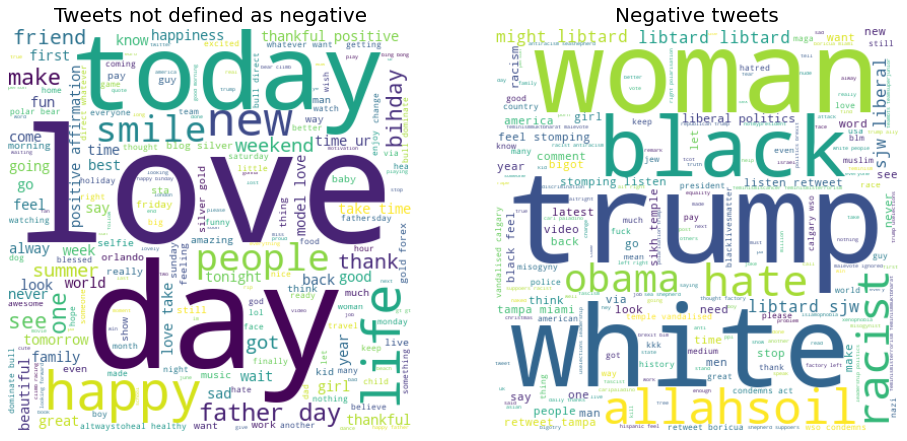

In [24]:
from wordcloud import WordCloud, STOPWORDS
stopwords = STOPWORDS.add('amp')

neutral_words = ' '.join(dataset[dataset.label == 0].tweet.values)
hatred_words = ' '.join(dataset[dataset.label == 1].tweet.values)

plt.figure(figsize=(16, 8))

cloud1 = WordCloud(width = 400, height = 400, background_color='white', stopwords = stopwords).generate(neutral_words)
plt.subplot(121)
plt.imshow(cloud1, interpolation = "bilinear")
plt.axis("off")
plt.title('Tweets not defined as negative', size = 20)

cloud2 = WordCloud(width = 400, height = 400, background_color = 'white', stopwords = stopwords).generate(hatred_words)
plt.subplot(122)
plt.imshow(cloud2, interpolation = "bilinear")
plt.axis("off")
plt.title('Negative tweets', size = 20)
plt.show()

# **Feature extraction**

Text classification on the basis of:

- Words used in hashtags
- Number of mentions in the tweet
- Words used in tweets

### **Analysis of the words in hashtags**

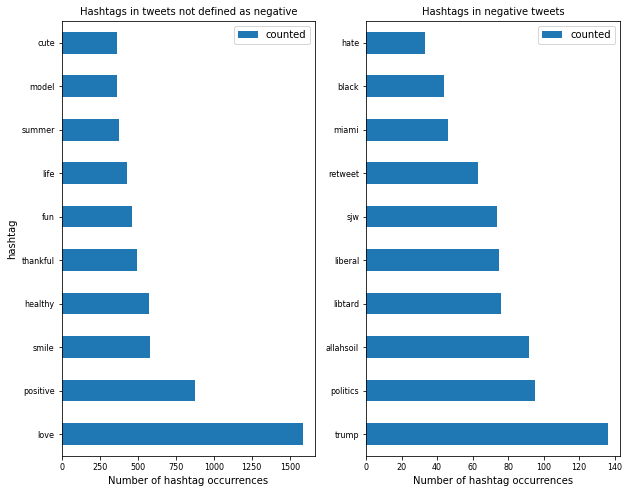

In [25]:
from nltk import pos_tag, FreqDist, word_tokenize

neutral_hashtags = []
hatred_hashtags = []

neutral_hashtags = FreqDist(list(' '.join(dataset[dataset.label == 0].hashtags.values).split())).most_common(10)
hatred_hashtags = FreqDist(list(' '.join(dataset[dataset.label == 1].hashtags.values).split())).most_common(10)

plt.figure(figsize=(10, 8))

ax = plt.subplot(121)
pd.DataFrame(neutral_hashtags, columns=['hashtag', 'counted']).set_index('hashtag').plot.barh(ax = ax, fontsize = 8)
plt.xlabel('Number of hashtag occurrences')
plt.title('Hashtags in tweets not defined as negative', size = 10)

ax = plt.subplot(122)
pd.DataFrame(hatred_hashtags, columns=['hashtag', 'counted']).set_index('hashtag').plot.barh(ax = ax, fontsize = 8)
plt.xlabel('Number of hashtag occurrences')
plt.ylabel('')
plt.title('Hashtags in negative tweets', size = 10)
plt.show()

In [ ]:
all_hashtags2 = []
hatred_hashtags2 = []

all_hashtags2 = FreqDist(list(' '.join(dataset.hashtags.values).split()))
hatred_hashtags2 = FreqDist(list(' '.join(dataset[dataset.label == 1].hashtags.values).split()))

In [ ]:
print("Number of all hashtags: {}".format(len(all_hashtags2)))
print("Number of negative hashtags: {}".format(len(hatred_hashtags2)))

Number of all hashtags: 23013
Number of negative hashtags: 1886


In [ ]:
dataset

,id,label,tweet,hashtags,mentions
0,1,0,father dysfunctional selfish drag kid dysfunct...,run,1
1,2,0,thanks lyft credit use cause offer wheelchair ...,lyft disapointed getthanked,2
2,3,0,bihday majesty,,0
3,4,0,model love take time ur,model,0
4,5,0,factsguide society motivation,motivation,0
...,...,...,...,...,...
31957,31958,0,ate isz youuu,,1
31958,31959,0,see nina turner airwave trying wrap mantle gen...,shame imwithher,0
31959,31960,0,listening sad song monday morning otw work sad,,0
31960,31961,1,sikh temple vandalised calgary wso condemns act,sikh temple calgary wso,1


In [ ]:
features_hashtags = []
vectorizer = TfidfVectorizer(stop_words = stopwords.words('english'), ngram_range = (1, 3), min_df = 10) 
features_hashtags = vectorizer.fit_transform(dataset.hashtags)

### **Mentions in the tweets**

In [ ]:
print("Number of mentions: {}\nNumber of tweets having a mention: {}\nCorrelation with label: {}".format(
    dataset.mentions.sum(),
    len(dataset[dataset.mentions > 0]),
    np.corrcoef(dataset.mentions, dataset.label)[0][1]
))

Number of mentions: 17571
Number of tweets having a mention: 11126
Correlation with label: 0.07851491623991766


The correlation coefficient is too small for there to be a useful relationship between the number of mentions and the sentiment of the tweet.

In [ ]:
dataset.head()

,id,label,tweet,hashtags,mentions
0,1,0,father dysfunctional selfish drag kid dysfunct...,run,1
1,2,0,thanks lyft credit use cause offer wheelchair ...,lyft disapointed getthanked,2
2,3,0,bihday majesty,,0
3,4,0,model love take time ur,model,0
4,5,0,factsguide society motivation,motivation,0


In [ ]:
dataset.drop('mentions', axis = 1, inplace = True)

In [ ]:
dataset.head()

,id,label,tweet,hashtags
0,1,0,father dysfunctional selfish drag kid dysfunct...,run
1,2,0,thanks lyft credit use cause offer wheelchair ...,lyft disapointed getthanked
2,3,0,bihday majesty,
3,4,0,model love take time ur,model
4,5,0,factsguide society motivation,motivation


### **Number of occurrences of words in tweets**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

features = []
vectorizer = TfidfVectorizer(stop_words = stopwords.words('english'), ngram_range = (1, 3), min_df = 10) 
features = vectorizer.fit_transform(dataset.tweet)

# **Machine learning**

## **Teaching the model**

**The Support Vector Machine was used**

SVM and SVC are different implementations of the same algorithm. The SVM module (SVC, NuSVC, etc.) is a wrapper around the libsvm library and supports different kernels, while LinearSVC is based on liblinear and supports only the linear kernel, ie: SVC(kernel = 'linear').

### **Features - words used in hashtags**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score

y = dataset.label.values
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(features_hashtags, y, test_size = 0.2, random_state = 1, stratify = y)

**Linear regression**

To find the best threshold.

Best parameters found were {'C': 30, 'penalty': 'l1'} with F1 score of 0.52


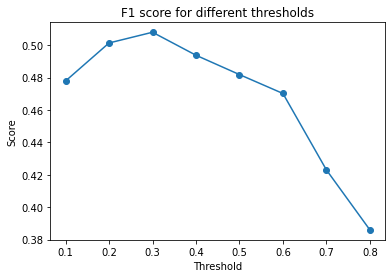

In [ ]:
params = {'penalty': ['l1', 'l2'], 'C': [3, 10, 30, 100, 300]}
LR_model = GridSearchCV(LogisticRegression(solver='liblinear', max_iter = 150), param_grid = params, scoring = 'f1', cv = 5, n_jobs = -1)
LR_model.fit(X_train_h, y_train_h)
print("Best parameters found were {} with F1 score of {:.2f}".format(
    LR_model.best_params_,
    LR_model.best_score_
))

probas = LR_model.predict_proba(X_test_h)
thresholds = np.arange(0.1, 0.9, 0.1)
scores = [f1_score(y_test_h, (probas[:, 1] >= x).astype(int)) for x in thresholds]
plt.plot(thresholds, scores, 'o-')
plt.title("F1 score for different thresholds")
plt.ylabel("Score")
plt.xlabel("Threshold")
plt.show()

In [ ]:
params = {'C': [1000, 3000, 9000, 15000]}

svc = GridSearchCV(SVC(kernel = 'rbf', gamma = 'auto'), param_grid = params, scoring = 'f1', cv = 3, n_jobs = -1)
svc.fit(X_train_h, y_train_h)
print("Best parameters found were {} with F1 score of {:.2f}".format(
    svc.best_params_,
    svc.best_score_
))

predictions = svc.predict(X_test_h)
print("\nF1 test score for SVC: {:.2f}".format(f1_score(y_test_h, predictions)))

Best parameters found were {'C': 3000} with F1 score of 0.51

F1 test score for SVC: 0.48


**For hashtag analysis - SVM model accuracy = 48%**

### **Features - words used in tweets.**

In [ ]:
y = dataset.label.values
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size = 0.2, random_state = 1, stratify = y)

**Linear regression**

To find the best threshold.

In [ ]:
X_train_2 = X_train
X_test_2 = X_test
y_train_2 = y_train
y_test_2 = y_test

Best parameters found were {'C': 30, 'penalty': 'l2'} with F1 score of 0.64


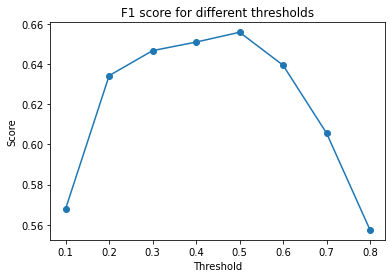

In [ ]:
params = {'penalty': ['l1', 'l2'], 'C': [3, 10, 30, 100, 300]}
LR_model = GridSearchCV(LogisticRegression(solver='liblinear', max_iter = 150), param_grid = params, scoring = 'f1', cv = 5, n_jobs = -1)
LR_model.fit(X_train_2, y_train_2)
print("Best parameters found were {} with F1 score of {:.2f}".format(
    LR_model.best_params_,
    LR_model.best_score_
))

probas = LR_model.predict_proba(X_test_2)
thresholds = np.arange(0.1, 0.9, 0.1)
scores = [f1_score(y_test_2, (probas[:, 1] >= x).astype(int)) for x in thresholds]
plt.plot(thresholds, scores, 'o-')
plt.title("F1 score for different thresholds")
plt.ylabel("Score")
plt.xlabel("Threshold")
plt.show()

In [ ]:
params = {'C': [1000, 3000, 9000, 15000]}
svc = GridSearchCV(SVC(kernel = 'rbf', gamma = 'auto'), param_grid = params, scoring = 'f1', cv = 3, n_jobs = -1)
svc.fit(X_train_2, y_train_2)
print("Best parameters found were {} with F1 score of {:.2f}".format(
    svc.best_params,
    svc.best_score
))
predictions = svc.predict(X_test_2)
print("\nF1 Test score for SVC: {:.2f}".format(f1_score(y_test_2, predictions)))

Best parameters found were {'C': 9000} with F1 score of 0.64

F1 test score for SVC: 0.64


**For whole tweets analysis - SVM model accuracy = 64%**

# **Deep learning - RNN**

# **Text classification based on the words used in the tweets**

In [ ]:
token = Tokenizer(28164)
token.fit_on_texts(dataset.tweet)
text = token.texts_to_sequences(dataset.tweet)
text = pad_sequences(text, maxlen = 100)

In [ ]:
text

array([[    0,     0,     0, ...,   118,  7004,   305],
       [    0,     0,     0, ...,  7006, 13617,  8938],
       [    0,     0,     0, ...,     0,    16,  2980],
       ...,
       [    0,     0,     0, ...,  6769,    25,    63],
       [    0,     0,     0, ...,  1419,  1420,   442],
       [    0,     0,     0, ...,     0,    96,    75]], dtype=int32)

## **Division of data into training and test data**

In [ ]:
y = dataset.label.values

In [ ]:
y

array([0, 0, 0, ..., 0, 1, 0])

In [ ]:
# Mixing up the order of the tweets

from sklearn.utils import shuffle
text, y = shuffle(text, y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(text, y, test_size = 0.2, random_state = 1, stratify = y)

In [ ]:
# Label vectorisation
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

In [ ]:
y_train

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

## **Building the model**

## **Model 1**

In [ ]:
# Model 1

max_features = 30000
embedding_dim = 32 #64
lstm_output_size = 32  #64

model = Sequential()
model.add(Embedding(max_features, embedding_dim))
model.add(Dropout(0.2))
model.add(LSTM(lstm_output_size, return_sequences = True))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, None, 32)          960000    
                                                                 
 dropout_40 (Dropout)        (None, None, 32)          0         
                                                                 
 lstm_20 (LSTM)              (None, None, 32)          8320      
                                                                 
 dropout_41 (Dropout)        (None, None, 32)          0         
                                                                 
 dense_20 (Dense)            (None, None, 1)           33        
                                                                 
 activation_20 (Activation)  (None, None, 1)           0         
                                                                 
Total params: 968,353
Trainable params: 968,353
Non-t

### **Model training - analysis of words in the tweets**

In [ ]:
batch_size = 1024

model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])
history = model.fit(X_train, y_train, batch_size = batch_size, validation_data=(X_test, y_test), epochs = 5)

score, acc = model.evaluate(X_test, y_test, batch_size = batch_size)
print('Test loss: {:.2f}%'.format(100*score))
print('Test accuracy: {:.2f}%'.format(100*acc))

Epoch 1/5
25/25 [==============================] - 14s 470ms/step - loss: 0.5526 - accuracy: 0.8887 - val_loss: 0.2880 - val_accuracy: 0.9299
Epoch 2/5
25/25 [==============================] - 16s 641ms/step - loss: 0.2827 - accuracy: 0.9298 - val_loss: 0.2690 - val_accuracy: 0.9299
Epoch 3/5
25/25 [==============================] - 11s 444ms/step - loss: 0.2702 - accuracy: 0.9298 - val_loss: 0.2659 - val_accuracy: 0.9299
Epoch 4/5
25/25 [==============================] - 11s 445ms/step - loss: 0.2677 - accuracy: 0.9298 - val_loss: 0.2639 - val_accuracy: 0.9299
Epoch 5/5
7/7 [==============================] - 1s 119ms/step - loss: 0.2620 - accuracy: 0.9299
Test loss: 26.20%
Test accuracy: 92.99%


#### **Changing the number of epochs**

In [ ]:
batch_size = 1024

model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size = batch_size, validation_data=(X_test, y_test), epochs = 10)

score, acc = model.evaluate(X_test, y_test, batch_size = batch_size)
print('Test loss: {:.2f}%'.format(100*score))
print('Test accuracy: {:.2f}%'.format(100*acc))

Epoch 1/10
25/25 [==============================] - 14s 465ms/step - loss: 0.5218 - accuracy: 0.9276 - val_loss: 0.2853 - val_accuracy: 0.9299
Epoch 2/10
25/25 [==============================] - 14s 564ms/step - loss: 0.2780 - accuracy: 0.9298 - val_loss: 0.2687 - val_accuracy: 0.9299
Epoch 3/10
25/25 [==============================] - 13s 514ms/step - loss: 0.2712 - accuracy: 0.9298 - val_loss: 0.2655 - val_accuracy: 0.9299
Epoch 4/10
25/25 [==============================] - 13s 514ms/step - loss: 0.2688 - accuracy: 0.9298 - val_loss: 0.2640 - val_accuracy: 0.9299
Epoch 5/10
25/25 [==============================] - 12s 468ms/step - loss: 0.2672 - accuracy: 0.9298 - val_loss: 0.2625 - val_accuracy: 0.9299
Epoch 6/10
25/25 [==============================] - 11s 439ms/step - loss: 0.2656 - accuracy: 0.9298 - val_loss: 0.2613 - val_accuracy: 0.9299
Epoch 7/10
25/25 [==============================] - 11s 442ms/step - loss: 0.2641 - accuracy: 0.9298 - val_loss: 0.2599 - val_accuracy: 0.9299

In [ ]:
batch_size = 1024

model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size = batch_size, validation_data=(X_test, y_test), epochs = 3)

score, acc = model.evaluate(X_test, y_test, batch_size = batch_size)
print('Test loss: {:.2f}%'.format(100*score))
print('Test accuracy: {:.2f}%'.format(100*acc))

Epoch 1/3
25/25 [==============================] - 14s 464ms/step - loss: 0.5322 - accuracy: 0.9082 - val_loss: 0.2830 - val_accuracy: 0.9299
Epoch 2/3
25/25 [==============================] - 11s 445ms/step - loss: 0.2805 - accuracy: 0.9298 - val_loss: 0.2687 - val_accuracy: 0.9299
Epoch 3/3
7/7 [==============================] - 1s 125ms/step - loss: 0.2661 - accuracy: 0.9299
Test loss: 26.61%
Test accuracy: 92.99%


#### **Changing the batch size**

In [ ]:
batch_size = 512

model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size = batch_size, validation_data=(X_test, y_test), epochs = 5)

score, acc = model.evaluate(X_test, y_test, batch_size = batch_size)
print('Test loss: {:.2f}%'.format(100*score))
print('Test accuracy: {:.2f}%'.format(100*acc))

Epoch 1/5
50/50 [==============================] - 16s 276ms/step - loss: 0.4008 - accuracy: 0.9076 - val_loss: 0.2692 - val_accuracy: 0.9299
Epoch 2/5
50/50 [==============================] - 13s 255ms/step - loss: 0.2702 - accuracy: 0.9298 - val_loss: 0.2648 - val_accuracy: 0.9299
Epoch 3/5
50/50 [==============================] - 11s 219ms/step - loss: 0.2665 - accuracy: 0.9298 - val_loss: 0.2617 - val_accuracy: 0.9299
Epoch 4/5
50/50 [==============================] - 11s 221ms/step - loss: 0.2633 - accuracy: 0.9298 - val_loss: 0.2591 - val_accuracy: 0.9299
Epoch 5/5
13/13 [==============================] - 1s 61ms/step - loss: 0.2569 - accuracy: 0.9299
Test loss: 25.69%
Test accuracy: 92.99%


In [ ]:
batch_size = 256

model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size = batch_size, validation_data=(X_test, y_test), epochs = 5)

score, acc = model.evaluate(X_test, y_test, batch_size = batch_size)
print('Test loss: {:.4f}'.format(score))
print('Test accuracy: {:.2f}%'.format(100*acc))

Epoch 1/5
100/100 [==============================] - 17s 136ms/step - loss: 0.3418 - accuracy: 0.9269 - val_loss: 0.2656 - val_accuracy: 0.9299
Epoch 2/5
100/100 [==============================] - 13s 130ms/step - loss: 0.2659 - accuracy: 0.9298 - val_loss: 0.2597 - val_accuracy: 0.9299
Epoch 3/5
100/100 [==============================] - 13s 130ms/step - loss: 0.2610 - accuracy: 0.9298 - val_loss: 0.2558 - val_accuracy: 0.9299
Epoch 4/5
100/100 [==============================] - 13s 129ms/step - loss: 0.2574 - accuracy: 0.9299 - val_loss: 0.2531 - val_accuracy: 0.9301
Epoch 5/5
25/25 [==============================] - 1s 37ms/step - loss: 0.2513 - accuracy: 0.9306
Test loss: 0.2513
Test accuracy: 93.06%


## **Model 2**

In [ ]:
# Model 2

max_features = 30000
embedding_dim = 64
lstm_output_size = 64

model = Sequential()
model.add(Embedding(max_features, embedding_dim))
model.add(Dropout(0.2))
model.add(LSTM(lstm_output_size, return_sequences = True))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 64)          1920000   
                                                                 
 dropout_18 (Dropout)        (None, None, 64)          0         
                                                                 
 lstm_9 (LSTM)               (None, None, 64)          33024     
                                                                 
 dropout_19 (Dropout)        (None, None, 64)          0         
                                                                 
 dense_9 (Dense)             (None, None, 1)           65        
                                                                 
 activation_9 (Activation)   (None, None, 1)           0         
                                                                 
Total params: 1,953,089
Trainable params: 1,953,089
No

### **Model training - analysis of words in the tweets**

In [ ]:
batch_size = 256

model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])
history = model.fit(X_train, y_train, batch_size = batch_size, validation_data=(X_test, y_test), epochs = 5)

score, acc = model.evaluate(X_test, y_test, batch_size = batch_size)
print('Test loss: {:.2f}%'.format(100*score))
print('Test accuracy: {:.2f}%'.format(100*acc))

Epoch 1/5
100/100 [==============================] - 36s 323ms/step - loss: 0.3160 - accuracy: 0.9187 - val_loss: 0.2615 - val_accuracy: 0.9299
Epoch 2/5
100/100 [==============================] - 32s 318ms/step - loss: 0.2602 - accuracy: 0.9299 - val_loss: 0.2560 - val_accuracy: 0.9301
Epoch 3/5
100/100 [==============================] - 36s 360ms/step - loss: 0.2547 - accuracy: 0.9305 - val_loss: 0.2514 - val_accuracy: 0.9307
Epoch 4/5
100/100 [==============================] - 35s 346ms/step - loss: 0.2507 - accuracy: 0.9314 - val_loss: 0.2496 - val_accuracy: 0.9312
Epoch 5/5
25/25 [==============================] - 2s 84ms/step - loss: 0.2484 - accuracy: 0.9314
Test loss: 24.84%
Test accuracy: 93.14%


**For the analysis of all tweets - RNN model accuracy = 93.14%**

# **Text classification based on the words used in the hashtags**

In [ ]:
token = Tokenizer(28164)
token.fit_on_texts(dataset.hashtags)
text2 = token.texts_to_sequences(dataset.hashtags)
text2 = pad_sequences(text2, maxlen = 100)

In [ ]:
# Model 1

max_features = 30000
embedding_dim = 32 #64
lstm_output_size = 32  #64

model = Sequential()
model.add(Embedding(max_features, embedding_dim))
model.add(Dropout(0.2))
model.add(LSTM(lstm_output_size, return_sequences = True))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, None, 32)          960000    
                                                                 
 dropout_36 (Dropout)        (None, None, 32)          0         
                                                                 
 lstm_18 (LSTM)              (None, None, 32)          8320      
                                                                 
 dropout_37 (Dropout)        (None, None, 32)          0         
                                                                 
 dense_18 (Dense)            (None, None, 1)           33        
                                                                 
 activation_18 (Activation)  (None, None, 1)           0         
                                                                 
Total params: 968,353
Trainable params: 968,353
Non-t

In [ ]:
# Model 2

max_features = 30000
embedding_dim = 64
lstm_output_size = 64

model = Sequential()
model.add(Embedding(max_features, embedding_dim))
model.add(Dropout(0.2))
model.add(LSTM(lstm_output_size, return_sequences = True))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, None, 64)          1920000   
                                                                 
 dropout_38 (Dropout)        (None, None, 64)          0         
                                                                 
 lstm_19 (LSTM)              (None, None, 64)          33024     
                                                                 
 dropout_39 (Dropout)        (None, None, 64)          0         
                                                                 
 dense_19 (Dense)            (None, None, 1)           65        
                                                                 
 activation_19 (Activation)  (None, None, 1)           0         
                                                                 
Total params: 1,953,089
Trainable params: 1,953,089
N

## **Division of data into training and test data**

In [ ]:
y = dataset.label.values

In [ ]:
y

array([0, 0, 0, ..., 0, 1, 0])

In [ ]:
# Mixing up the order of the tweets

from sklearn.utils import shuffle
text, y = shuffle(text2, y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(text2, y, test_size = 0.2, random_state = 1, stratify = y)

In [ ]:
# Label vectorisation
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

In [ ]:
y_train

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

## **Model 1**

In [ ]:
batch_size = 1024

model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])
history = model.fit(X_train, y_train, batch_size = batch_size, validation_data=(X_test, y_test), epochs = 5)

score, acc = model.evaluate(X_test, y_test, batch_size = batch_size)
print('Test loss: {:.2f}%'.format(100*score))
print('Test accuracy: {:.2f}%'.format(100*acc))

Epoch 1/5
25/25 [==============================] - 15s 531ms/step - loss: 0.5218 - accuracy: 0.9198 - val_loss: 0.2791 - val_accuracy: 0.9299
Epoch 2/5
25/25 [==============================] - 11s 446ms/step - loss: 0.2803 - accuracy: 0.9298 - val_loss: 0.2691 - val_accuracy: 0.9299
Epoch 3/5
25/25 [==============================] - 11s 449ms/step - loss: 0.2710 - accuracy: 0.9298 - val_loss: 0.2665 - val_accuracy: 0.9299
Epoch 4/5
25/25 [==============================] - 11s 444ms/step - loss: 0.2689 - accuracy: 0.9298 - val_loss: 0.2648 - val_accuracy: 0.9299
Epoch 5/5
7/7 [==============================] - 1s 123ms/step - loss: 0.2633 - accuracy: 0.9299
Test loss: 26.33%
Test accuracy: 92.99%


#### **Changing the number of epochs**

In [ ]:
batch_size = 1024

model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size = batch_size, validation_data=(X_test, y_test), epochs = 3)

score, acc = model.evaluate(X_test, y_test, batch_size = batch_size)
print('Test loss: {:.2f}%'.format(100*score))
print('Test accuracy: {:.2f}%'.format(100*acc))

Epoch 1/3
25/25 [==============================] - 15s 505ms/step - loss: 0.5157 - accuracy: 0.9116 - val_loss: 0.2805 - val_accuracy: 0.9299
Epoch 2/3
25/25 [==============================] - 11s 448ms/step - loss: 0.2812 - accuracy: 0.9298 - val_loss: 0.2690 - val_accuracy: 0.9299
Epoch 3/3
7/7 [==============================] - 1s 125ms/step - loss: 0.2664 - accuracy: 0.9299
Test loss: 26.64%
Test accuracy: 92.99%


In [ ]:
batch_size = 1024

model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size = batch_size, validation_data = (X_test, y_test), epochs = 10)

score, acc = model.evaluate(X_test, y_test, batch_size = batch_size)
print('Test loss: {:.2f}%'.format(100*score))
print('Test accuracy: {:.2f}%'.format(100*acc))

Epoch 1/10
25/25 [==============================] - 19s 594ms/step - loss: 0.5577 - accuracy: 0.8675 - val_loss: 0.2999 - val_accuracy: 0.9299
Epoch 2/10
25/25 [==============================] - 11s 445ms/step - loss: 0.2833 - accuracy: 0.9298 - val_loss: 0.2698 - val_accuracy: 0.9299
Epoch 3/10
25/25 [==============================] - 11s 450ms/step - loss: 0.2717 - accuracy: 0.9298 - val_loss: 0.2669 - val_accuracy: 0.9299
Epoch 4/10
25/25 [==============================] - 11s 449ms/step - loss: 0.2692 - accuracy: 0.9298 - val_loss: 0.2652 - val_accuracy: 0.9299
Epoch 5/10
25/25 [==============================] - 11s 448ms/step - loss: 0.2677 - accuracy: 0.9298 - val_loss: 0.2637 - val_accuracy: 0.9299
Epoch 6/10
25/25 [==============================] - 11s 444ms/step - loss: 0.2664 - accuracy: 0.9298 - val_loss: 0.2625 - val_accuracy: 0.9299
Epoch 7/10
25/25 [==============================] - 11s 447ms/step - loss: 0.2653 - accuracy: 0.9298 - val_loss: 0.2614 - val_accuracy: 0.9299

In [ ]:
batch_size = 1024

model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size = batch_size, validation_data = (X_test, y_test), epochs = 15)

score, acc = model.evaluate(X_test, y_test, batch_size = batch_size)
print('Test loss: {:.2f}%'.format(100*score))
print('Test accuracy: {:.2f}%'.format(100*acc))

Epoch 1/15
25/25 [==============================] - 21s 725ms/step - loss: 0.5452 - accuracy: 0.8777 - val_loss: 0.2959 - val_accuracy: 0.9299
Epoch 2/15
25/25 [==============================] - 11s 453ms/step - loss: 0.2833 - accuracy: 0.9298 - val_loss: 0.2702 - val_accuracy: 0.9299
Epoch 3/15
25/25 [==============================] - 11s 452ms/step - loss: 0.2721 - accuracy: 0.9298 - val_loss: 0.2670 - val_accuracy: 0.9299
Epoch 4/15
25/25 [==============================] - 11s 452ms/step - loss: 0.2699 - accuracy: 0.9298 - val_loss: 0.2654 - val_accuracy: 0.9299
Epoch 5/15
25/25 [==============================] - 11s 451ms/step - loss: 0.2682 - accuracy: 0.9298 - val_loss: 0.2639 - val_accuracy: 0.9299
Epoch 6/15
25/25 [==============================] - 12s 485ms/step - loss: 0.2667 - accuracy: 0.9298 - val_loss: 0.2627 - val_accuracy: 0.9299
Epoch 7/15
25/25 [==============================] - 11s 454ms/step - loss: 0.2655 - accuracy: 0.9298 - val_loss: 0.2617 - val_accuracy: 0.9299

In [ ]:
batch_size = 1024

model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size = batch_size, validation_data = (X_test, y_test), epochs = 30)

score, acc = model.evaluate(X_test, y_test, batch_size = batch_size)
print('Test loss: {:.2f}%'.format(100*score))
print('Test accuracy: {:.2f}%'.format(100*acc))

Epoch 1/30
25/25 [==============================] - 17s 537ms/step - loss: 0.5619 - accuracy: 0.8974 - val_loss: 0.3252 - val_accuracy: 0.9299
Epoch 2/30
25/25 [==============================] - 11s 443ms/step - loss: 0.2835 - accuracy: 0.9298 - val_loss: 0.2702 - val_accuracy: 0.9299
Epoch 3/30
25/25 [==============================] - 11s 440ms/step - loss: 0.2715 - accuracy: 0.9298 - val_loss: 0.2662 - val_accuracy: 0.9299
Epoch 4/30
25/25 [==============================] - 11s 444ms/step - loss: 0.2688 - accuracy: 0.9298 - val_loss: 0.2646 - val_accuracy: 0.9299
Epoch 5/30
25/25 [==============================] - 11s 442ms/step - loss: 0.2673 - accuracy: 0.9298 - val_loss: 0.2632 - val_accuracy: 0.9299
Epoch 6/30
25/25 [==============================] - 11s 442ms/step - loss: 0.2659 - accuracy: 0.9298 - val_loss: 0.2620 - val_accuracy: 0.9299
Epoch 7/30
25/25 [==============================] - 11s 443ms/step - loss: 0.2648 - accuracy: 0.9298 - val_loss: 0.2610 - val_accuracy: 0.9299

Number of epochs = 30:

After the 15th epoch val_loss increases with some of the subsequent epochs (overtraining of the model). Therefore, the best number of epochs is equal to 15.

#### **Changing the batch size**

In [ ]:
batch_size = 512

model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size = batch_size, validation_data=(X_test, y_test), epochs = 15)

score, acc = model.evaluate(X_test, y_test, batch_size = batch_size)
print('Test loss: {:.2f}%'.format(100*score))
print('Test accuracy: {:.2f}%'.format(100*acc))

Epoch 1/15
50/50 [==============================] - 16s 238ms/step - loss: 0.4278 - accuracy: 0.9044 - val_loss: 0.2698 - val_accuracy: 0.9299
Epoch 2/15
50/50 [==============================] - 11s 217ms/step - loss: 0.2698 - accuracy: 0.9298 - val_loss: 0.2650 - val_accuracy: 0.9299
Epoch 3/15
50/50 [==============================] - 12s 233ms/step - loss: 0.2665 - accuracy: 0.9298 - val_loss: 0.2622 - val_accuracy: 0.9299
Epoch 4/15
50/50 [==============================] - 11s 218ms/step - loss: 0.2639 - accuracy: 0.9298 - val_loss: 0.2605 - val_accuracy: 0.9299
Epoch 5/15
50/50 [==============================] - 11s 217ms/step - loss: 0.2622 - accuracy: 0.9298 - val_loss: 0.2587 - val_accuracy: 0.9299
Epoch 6/15
50/50 [==============================] - 11s 220ms/step - loss: 0.2608 - accuracy: 0.9298 - val_loss: 0.2579 - val_accuracy: 0.9299
Epoch 7/15
50/50 [==============================] - 11s 227ms/step - loss: 0.2601 - accuracy: 0.9298 - val_loss: 0.2570 - val_accuracy: 0.9299

In [ ]:
batch_size = 256

model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size = batch_size, validation_data=(X_test, y_test), epochs = 15)

score, acc = model.evaluate(X_test, y_test, batch_size = batch_size)
print('Test loss: {:.4f}'.format(score))
print('Test accuracy: {:.2f}%'.format(100*acc))

Epoch 1/15
100/100 [==============================] - 15s 130ms/step - loss: 0.3366 - accuracy: 0.9254 - val_loss: 0.2640 - val_accuracy: 0.9299
Epoch 2/15
100/100 [==============================] - 12s 124ms/step - loss: 0.2650 - accuracy: 0.9298 - val_loss: 0.2602 - val_accuracy: 0.9299
Epoch 3/15
100/100 [==============================] - 12s 125ms/step - loss: 0.2624 - accuracy: 0.9298 - val_loss: 0.2584 - val_accuracy: 0.9299
Epoch 4/15
100/100 [==============================] - 13s 126ms/step - loss: 0.2606 - accuracy: 0.9298 - val_loss: 0.2577 - val_accuracy: 0.9299
Epoch 5/15
100/100 [==============================] - 12s 124ms/step - loss: 0.2596 - accuracy: 0.9298 - val_loss: 0.2566 - val_accuracy: 0.9299
Epoch 6/15
100/100 [==============================] - 13s 126ms/step - loss: 0.2588 - accuracy: 0.9298 - val_loss: 0.2559 - val_accuracy: 0.9299
Epoch 7/15
100/100 [==============================] - 12s 123ms/step - loss: 0.2579 - accuracy: 0.9298 - val_loss: 0.2556 - val_ac

## **Model 2**

In [ ]:
batch_size = 256

model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size = batch_size, validation_data=(X_test, y_test), epochs = 15)

score, acc = model.evaluate(X_test, y_test, batch_size = batch_size)
print('Test loss: {:.4f}'.format(score))
print('Test accuracy: {:.2f}%'.format(100*acc))

Epoch 1/15
100/100 [==============================] - 37s 330ms/step - loss: 0.3062 - accuracy: 0.9266 - val_loss: 0.2625 - val_accuracy: 0.9299
Epoch 2/15
100/100 [==============================] - 32s 321ms/step - loss: 0.2628 - accuracy: 0.9298 - val_loss: 0.2584 - val_accuracy: 0.9299
Epoch 3/15
100/100 [==============================] - 32s 318ms/step - loss: 0.2599 - accuracy: 0.9298 - val_loss: 0.2570 - val_accuracy: 0.9299
Epoch 4/15
100/100 [==============================] - 32s 316ms/step - loss: 0.2582 - accuracy: 0.9298 - val_loss: 0.2565 - val_accuracy: 0.9299
Epoch 5/15
100/100 [==============================] - 32s 324ms/step - loss: 0.2571 - accuracy: 0.9298 - val_loss: 0.2558 - val_accuracy: 0.9299
Epoch 6/15
100/100 [==============================] - 31s 315ms/step - loss: 0.2568 - accuracy: 0.9298 - val_loss: 0.2551 - val_accuracy: 0.9299
Epoch 7/15
100/100 [==============================] - 32s 315ms/step - loss: 0.2560 - accuracy: 0.9298 - val_loss: 0.2544 - val_ac

**For the analysis of hashtags and whole tweets, the quality of the RNN classifier came out similar. The best accuracy for the hashtag analysis is 92.99%**